In [53]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [76]:
# Load the JSON data
with open('Combined_QnA_eng_India_election_2024.json', 'r') as file_eng:
    articles_eng = json.load(file_eng)

with open('Combined_QnA_hin_India_election_2024.json', 'r') as file_hin:
    articles_hin = json.load(file_hin)


In [77]:
def prepare_data(articles):
    # Extract questions and answers
    M = len(articles)
    questions = articles[0]['QnA']
    N = len(questions)

    # Create answer matrix
    answer_matrix = np.zeros((M, N), dtype=int)
    Kn = [0] * N  # Initialize number of categories per question

    for i, article in enumerate(articles):
        for j, qna in enumerate(article['QnA']):
            answer_matrix[i, j] = ord(qna['post_LLM_answer']) - ord('A') + 1  # Convert answers to integers
            Kn[j] = max(Kn[j], answer_matrix[i, j])  # Update the number of categories for each question

    return M, N, answer_matrix, Kn

In [87]:
class FactorModel(nn.Module):
    def __init__(self, N, Kn, d, M, dropout_rate=0.5):
        super(FactorModel, self).__init__()
        self.d = d
        self.Wn = nn.ParameterList([nn.Parameter(torch.randn(Kn[i]-1, d) * 0.01) for i in range(N)])
        self.bn = nn.ParameterList([nn.Parameter(torch.zeros(Kn[i]-1)) for i in range(N)])
        self.vm = nn.Parameter(torch.randn(M, d) * 0.01)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(d)

    def forward(self, m, n):
        vm = self.vm[m]
        vm = self.layer_norm(vm)  # Apply layer normalization
        vm = self.dropout(vm)     # Apply dropout
        Wn = self.Wn[n]
        bn = self.bn[n]
        fn = torch.matmul(Wn, vm) + bn
        prob = torch.softmax(fn, dim=0)
        return prob

In [88]:
def loss_function(model, answer_matrix, M, N, lambda_l2=0.001):
    epsilon = 1e-9  # Small constant to prevent log(0)
    loss = 0
    l2_reg = torch.tensor(0., dtype=torch.float32, requires_grad=True)
    for m in range(M):
        for n in range(N):
            k = answer_matrix[m, n] - 1  # Convert to zero-based index
            prob = model(m, n)
            l2_reg = l2_reg + torch.norm(model.vm[m])**2 + torch.norm(model.Wn[n])**2
            if k < prob.size(0):  # Ensure k is within bounds
                if torch.isnan(prob).any():
                    print(f'NaN found in prob for article {m} question {n}')
                log_prob = torch.log(prob[k] + epsilon)  # Add small value to prevent log(0)
                if torch.isnan(log_prob) or log_prob.item() == -float('inf'):
                    print(f'Invalid log_prob for article {m} question {n}: prob[{k}] = {prob[k].item()}')
                    print(f'prob = {prob}')
                loss -= log_prob
            else:  # Handle the case when k is the last category
                last_prob = 1 - prob.sum() + epsilon
                # Correct last_prob to be within valid range
                last_prob = torch.clamp(last_prob, min=epsilon)
                if last_prob <= 0 or torch.isnan(last_prob):
                    print(f'Invalid last_prob for article {m} question {n}: {last_prob.item()}')
                    print(f'prob sum = {prob.sum().item()}')
                    print(f'prob = {prob}')
                loss -= torch.log(last_prob)
    loss += lambda_l2 * l2_reg  # Add L2 regularization
    return loss



In [89]:
def train_model(articles, answer_matrix, M, N, Kn, d=10, dropout_rate=0.5, lr=0.0001, num_epochs=100):
    model = FactorModel(N, Kn, d, M, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_function(model, answer_matrix, M, N)
        if torch.isnan(loss):
            print(f'NaN loss encountered at epoch {epoch + 1}')
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model.vm.detach().numpy()

In [95]:
M1, N1, answer_matrix1, Kn1 = prepare_data(articles_eng)
embeddings1 = train_model(articles_eng, answer_matrix1, M1, N1, Kn1)

Epoch [10/100], Loss: 22600.8477
Epoch [20/100], Loss: 22606.9102
Epoch [30/100], Loss: 22553.3926
Epoch [40/100], Loss: 22498.0371
Epoch [50/100], Loss: 22650.5742
Epoch [60/100], Loss: 22474.8809
Epoch [70/100], Loss: 22511.3203
Epoch [80/100], Loss: 22628.6836
Epoch [90/100], Loss: 22608.5879
Epoch [100/100], Loss: 22563.1602


In [96]:
M2, N2, answer_matrix2, Kn2 = prepare_data(articles_hin)
embeddings2 = train_model(articles_hin, answer_matrix2, M2, N2, Kn2)

Epoch [10/100], Loss: 20912.3945
Epoch [20/100], Loss: 20797.4668
Epoch [30/100], Loss: 20933.7383
Epoch [40/100], Loss: 20776.5605
Epoch [50/100], Loss: 20818.6328
Epoch [60/100], Loss: 20829.3887
Epoch [70/100], Loss: 20895.3262
Epoch [80/100], Loss: 20745.8535
Epoch [90/100], Loss: 20865.0840
Epoch [100/100], Loss: 20835.3887


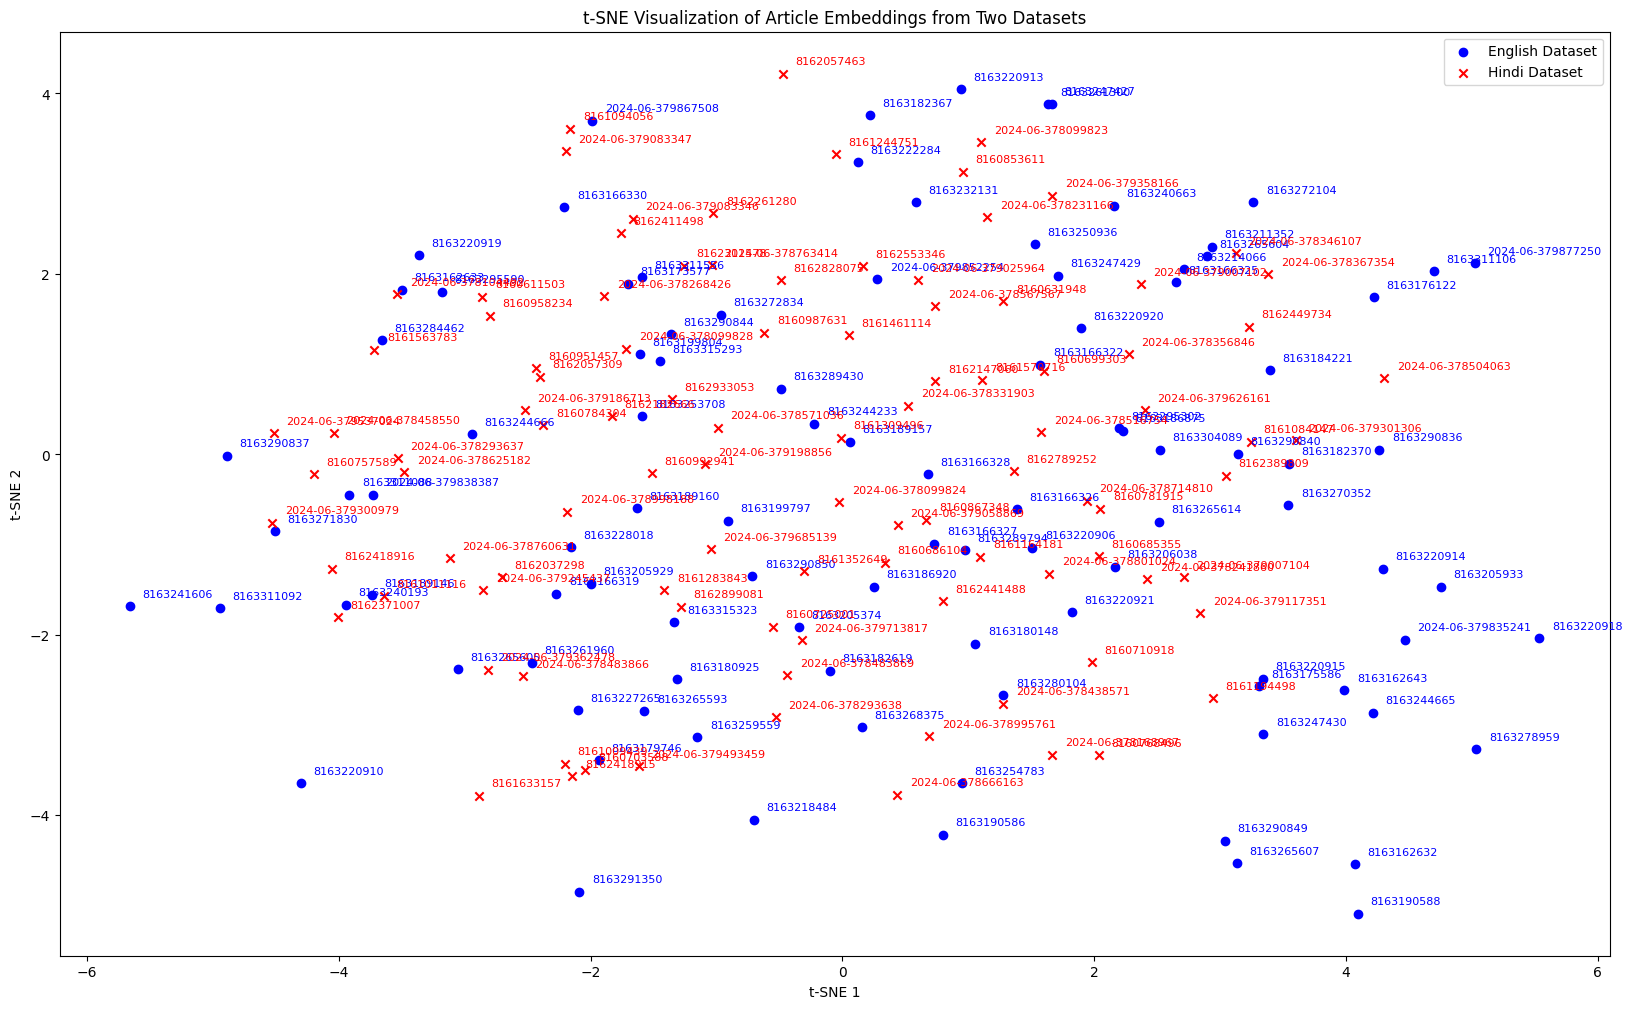

In [100]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Use t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_1 = tsne.fit_transform(embeddings1)
embeddings_2d_2 = tsne.fit_transform(embeddings2)

# Increase the plot size
plt.figure(figsize=(20, 12))

# Plot the embeddings from the first JSON (English)
plt.scatter(embeddings_2d_1[:, 0], embeddings_2d_1[:, 1], c='blue', marker='o', label='English Dataset')
for i, article in enumerate(articles_eng):
    plt.text(embeddings_2d_1[i, 0] + 0.1, embeddings_2d_1[i, 1] + 0.1, article['uri'], fontsize=8, color='blue')

# Plot the embeddings from the second JSON (Hindi)
plt.scatter(embeddings_2d_2[:, 0], embeddings_2d_2[:, 1], c='red', marker='x', label='Hindi Dataset')
for i, article in enumerate(articles_hin):
    plt.text(embeddings_2d_2[i, 0] + 0.1, embeddings_2d_2[i, 1] + 0.1, article['uri'], fontsize=8, color='red')

plt.title('t-SNE Visualization of Article Embeddings from Two Datasets')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()




In [104]:
#Print answers of two artciles in two different languages given the uri
def print_answers(articles, uri):
    for article in articles:
        if article['uri'] == uri:
            print(f'Answers for article {uri}:')
            for qna in article['QnA']:
                print(f'Answer: {qna["post_LLM_answer"]}')
            return
    print(f'Article with URI {uri} not found')

In [106]:
print_answers(articles_eng, '8163284462')
print_answers(articles_hin, '8163284462')

Answers for article 8163284462:
Answer: A
Answer: A
Answer: A
Answer: A
Answer: A
Answer: D
Answer: C
Answer: D
Answer: C
Answer: A
Answer: A
Answer: C
Answer: D
Answer: D
Answer: D
Answer: D
Answer: D
Answer: D
Answer: D
Answer: D
Answer: E
Answer: A
Article with URI 8163284462 not found
